In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
import scipy.stats as stats
import tqdm
import matplotlib.cm as col
colormap_normal = col.get_cmap("viridis")

/tmp/zu992399/login23-3_2628786/ipykernel_3285633/1122460586.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap_normal = col.get_cmap("viridis")


In [2]:
plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['font.serif'] = []
plt.rcParams['text.usetex'] = False
#plt.rcParams['figure.figsize'] = 3.5, 2.625
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['errorbar.capsize'] = 2
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fontsize'] = 12
#plt.rcParams['legend.frameon'] = False

In [3]:
generate_data = True
directory = "/hpcwork/zu992399/look_elsewhere/binned_test/"

bins = 5
bins_edge = 2
N = 10000
N_tests = 100000

# Generate Data

In [5]:
def draw_data(N_data= 10000, mu=[0,0], sigma=[[1,0],[0,1]]):
    rv = multivariate_normal(mu, sigma)
    return  rv.rvs(mu, sigma, size=N_data), rv

def get_p_value(sig):
    return 2*(1-stats.norm.cdf(sig))

def p_value_poissonpoisson_2tailed(N_data, N_BT, k=0.5):
    p_value = 1-stats.nbinom.cdf(N_data-1, N_BT, k)
    p_left = stats.nbinom.cdf(N_data, N_BT, 0.5)
    return np.min(np.array([p_value, p_left]), axis=0)*2

def p_value_poissonpoisson(N_data, N_BT, k=0.5):
    return 1-stats.nbinom.cdf(N_data-1, N_BT, k)

def p_value_binomial(N_data, N_BT, N_total):
    p_value = 1-stats.binom.cdf(N_data-1, N_total, N_BT/N_total)
    p_left = stats.binom.cdf(N_data, N_total, N_BT/N_total) 
    return np.min(np.array([p_value, p_left]), axis=0)*2
    #return p_value

In [33]:
if generate_data:
    def sample_hist(N, exp):
        return np.random.binomial(N, exp/N)

    def do_test_val(N_tests, bins, N, bins_edge = None, val=True):
        rv = multivariate_normal([0,0], [[1,0],[0,1]])
        if bins_edge is None:
            edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
        else:
            edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]
        exp = np.zeros((bins,bins))
        for i in range(bins):
            for j in range(bins):
                exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

        p_train = np.zeros((bins,bins, N_tests))
        p_val = np.zeros((bins,bins, N_tests))
        p_train_val = np.zeros((bins,bins, N_tests))
        p_test = np.zeros((bins,bins, N_tests))
        for k in tqdm.tqdm(range(N_tests)):
            hist_train = sample_hist(N, exp)
            p_train[:,:,k] = p_value_binomial(hist_train, exp, N)
            if val: 
                hist_val = sample_hist(N, exp)
                p_val[:,:,k] = p_value_binomial(hist_val, exp, N)
                p_train_val[:,:,k] = p_value_binomial(hist_train+hist_val, exp*2, 2*N)
            hist_test = sample_hist(N, exp)
            p_test[:,:,k] = p_value_binomial(hist_test, exp, N)

        if val:
            return p_train, p_val, p_train_val, p_test 
        else:
            return p_train, p_test

    p_train, p_val, p_train_val, p_test = do_test_val(N_tests, bins, N, bins_edge=bins_edge)

    min_ind_on_train = np.argmin(p_train.reshape((bins*bins, N_tests)), axis=0)
    p_train_pick_on_train = [p_train.reshape((bins*bins,N_tests))[min_ind_on_train[i],i] for i in range(N_tests)]
    p_test_pick_on_train = [p_test.reshape((bins*bins,N_tests))[min_ind_on_train[i],i] for i in range(N_tests)]

    min_ind_on_train_val = np.argmin(np.argsort(np.argsort(p_train.reshape((bins*bins, N_tests)), axis=0), axis=0)+np.argsort(np.argsort(p_val.reshape((bins*bins,N_tests)), axis=0), axis=0), axis=0)
    p_train_pick_on_train_val = [p_train.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]
    p_val_pick_on_train_val = [p_val.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]
    p_train_val_pick_on_train_val = [p_train_val.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]
    p_test_pick_on_train_val = [p_test.reshape((bins*bins,N_tests))[min_ind_on_train_val[i],i] for i in range(N_tests)]

    np.save(directory+"validation/p_train_pick_on_train.npy", p_train_pick_on_train)
    np.save(directory+"validation/p_train_pick_on_train_val.npy", p_train_pick_on_train_val)
    np.save(directory+"validation/p_test_pick_on_train.npy", p_test_pick_on_train)
    np.save(directory+"validation/p_test_pick_on_train_val.npy", p_test_pick_on_train_val)
    np.save(directory+"validation/p_val_pick_on_train_val.npy", p_val_pick_on_train_val)
    np.save(directory+"validation/p_train_val_pick_on_train_val.npy", p_train_val_pick_on_train_val)

100%|██████████| 100000/100000 [01:02<00:00, 1596.74it/s]


In [ ]:
if generate_data:
    p_train_arr = np.zeros((10, N_tests))
    p_test_arr = np.zeros((10, N_tests))
    
    p_train, p_test = do_test_val(10*N_tests, bins, N, bins_edge=bins_edge, val=False)
    p_train_split = np.array_split(p_train, 10, axis=-1)
    p_test_split = np.array_split(p_test, 10, axis=-1) 
    for i in range(10):
        min_ind_on_train = np.argmin(p_train_split[i].reshape((bins*bins, N_tests)), axis=0)

        p_train_arr[i] = np.array([p_train_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
        p_test_arr[i] = np.array([p_test_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
    np.save(directory+"validation/p_train_10_tests.npy", p_train_arr)
    np.save(directory+"validation/p_test_10_tests.npy", p_test_arr)

In [48]:
if generate_data:
    p_train_arr = np.zeros((10, N_tests))
    p_test_arr = np.zeros((10, N_tests))
    
    p_train, p_test = do_test_val(10*N_tests, bins, N/2, bins_edge=bins_edge, val=False)
    p_train_split = np.array_split(p_train, 10, axis=-1)
    p_test_split = np.array_split(p_test, 10, axis=-1) 
    for i in range(10):
        min_ind_on_train = np.argmin(p_train_split[i].reshape((bins*bins, N_tests)), axis=0)

        p_train_arr[i] = np.array([p_train_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])
        p_test_arr[i] = np.array([p_test_split[i].reshape((bins*bins, N_tests))[min_ind_on_train[j],j] for j in range(N_tests)])

    np.save(directory+"validation/p_train_10_tests_half.npy", p_train_arr)
    np.save(directory+"validation/p_test_10_tests_half.npy", p_test_arr)

100%|██████████| 1000000/1000000 [05:28<00:00, 3046.18it/s]


In [81]:
def do_test_kfold_valset(N_tests, bins, N, bins_edge = None, folds=5, val=True):
    rv = multivariate_normal([0,0], [[1,0],[0,1]])
    if bins_edge is None:
        edges = np.histogramdd(rv.rvs(size=100000), bins=bins)[1]
    else:
        edges = [np.linspace(-2,2,bins+1), np.linspace(-bins_edge,bins_edge,bins+1)]

    exp = np.zeros((bins,bins))
    for i in range(bins):
        for j in range(bins):
            exp[i,j] = (rv.cdf([edges[0][i+1], edges[1][j+1]])+rv.cdf([edges[0][i], edges[1][j]]) - rv.cdf([edges[0][i+1], edges[1][j]])-rv.cdf([edges[0][i], edges[1][j+1]]))*N

    p_add = np.zeros((N_tests))
    p_add_with_val = np.zeros((N_tests))
    p_only_train = np.zeros((N_tests, bins*bins, folds))
    p_train = np.zeros((N_tests, bins*bins, folds))
    p_val = np.zeros((N_tests, bins*bins, folds))
    train_val_split = int((folds-1)/2)
    for k in tqdm.tqdm(range(N_tests)):
        hist = np.zeros((bins,bins, folds))
        N_test = np.zeros((folds))
        exp_test = np.zeros((folds))
        best_bin = np.zeros((folds), dtype=int)

        N_test_with_val = np.zeros((folds))
        exp_test_with_val = np.zeros((folds))
        best_bin_with_val = np.zeros((folds), dtype=int)

        for m in range(folds):
            hist[:,:,m] = sample_hist(N//folds, exp//folds)

        for m in range(folds):
            inds = np.roll(np.array(range(folds)), m)

            if val:
                p_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:train_val_split]],axis=-1), exp*(train_val_split)/folds, N*(train_val_split)/folds).flatten()
                p_val[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[train_val_split:-1]],axis=-1), exp*((folds-train_val_split-1))/folds, N*(folds-train_val_split-1)/folds).flatten()
            p_only_train[k,:,m] = p_value_binomial(np.sum(hist[:,:,inds[:-1]],axis=-1), exp*(folds-1)/folds, N*(folds-1)/folds).flatten()

            best_bin[m] = np.argmin(p_only_train[k, :,m])
            N_test[m] = hist[:,:,inds[-1]].flatten()[best_bin[m]]
            exp_test[m] = exp.flatten()[best_bin[m]]/5

            if val:
                best_bin_with_val[m] = np.argmin(np.argsort(np.argsort(p_train[k, :,m]))+np.argsort(np.argsort(p_val[k,:, m])))
                N_test_with_val[m] = hist[:,:,inds[-1]].flatten()[best_bin_with_val[m]]
                exp_test_with_val[m] = exp.flatten()[best_bin_with_val[m]]/5
            
        p_add[k] = p_value_binomial(np.sum(N_test), np.sum(exp_test), N)

        if val:
            p_add_with_val[k] = p_value_binomial(np.sum(N_test_with_val), np.sum(exp_test_with_val), N)

    if val:
        return p_add, p_add_with_val
    else:
        return p_add

if generate_data:
    print("hi") 
    #p_add, p_add_with_val = do_test_kfold_valset(N_tests, bins, N, bins_edge=bins_edge)
    #np.save(directory+"k_fold/addition_test.npy", p_add)
    #np.save(directory+"k_fold/addition_with_validation_test.npy", p_add_with_val)


hi


In [82]:
p_add = do_test_kfold_valset(N_tests*5, bins, N, bins_edge=bins_edge, val=False)
#np.save(directory+"k_fold/addition_method_test.npy", p_add.reshape(10, N_tests))

100%|██████████| 500000/500000 [09:00<00:00, 925.75it/s]


In [83]:
p_add2 = do_test_kfold_valset(N_tests*5, bins, N, bins_edge=bins_edge, val=False)
#np.save(directory+"k_fold/addition_method_test.npy", p_add.reshape(10, N_tests))

100%|██████████| 500000/500000 [09:06<00:00, 915.24it/s]


In [84]:
np.save(directory+"k_fold/addition_method_test.npy", np.concatenate((p_add, p_add2)).reshape(10, N_tests))

# Plot results

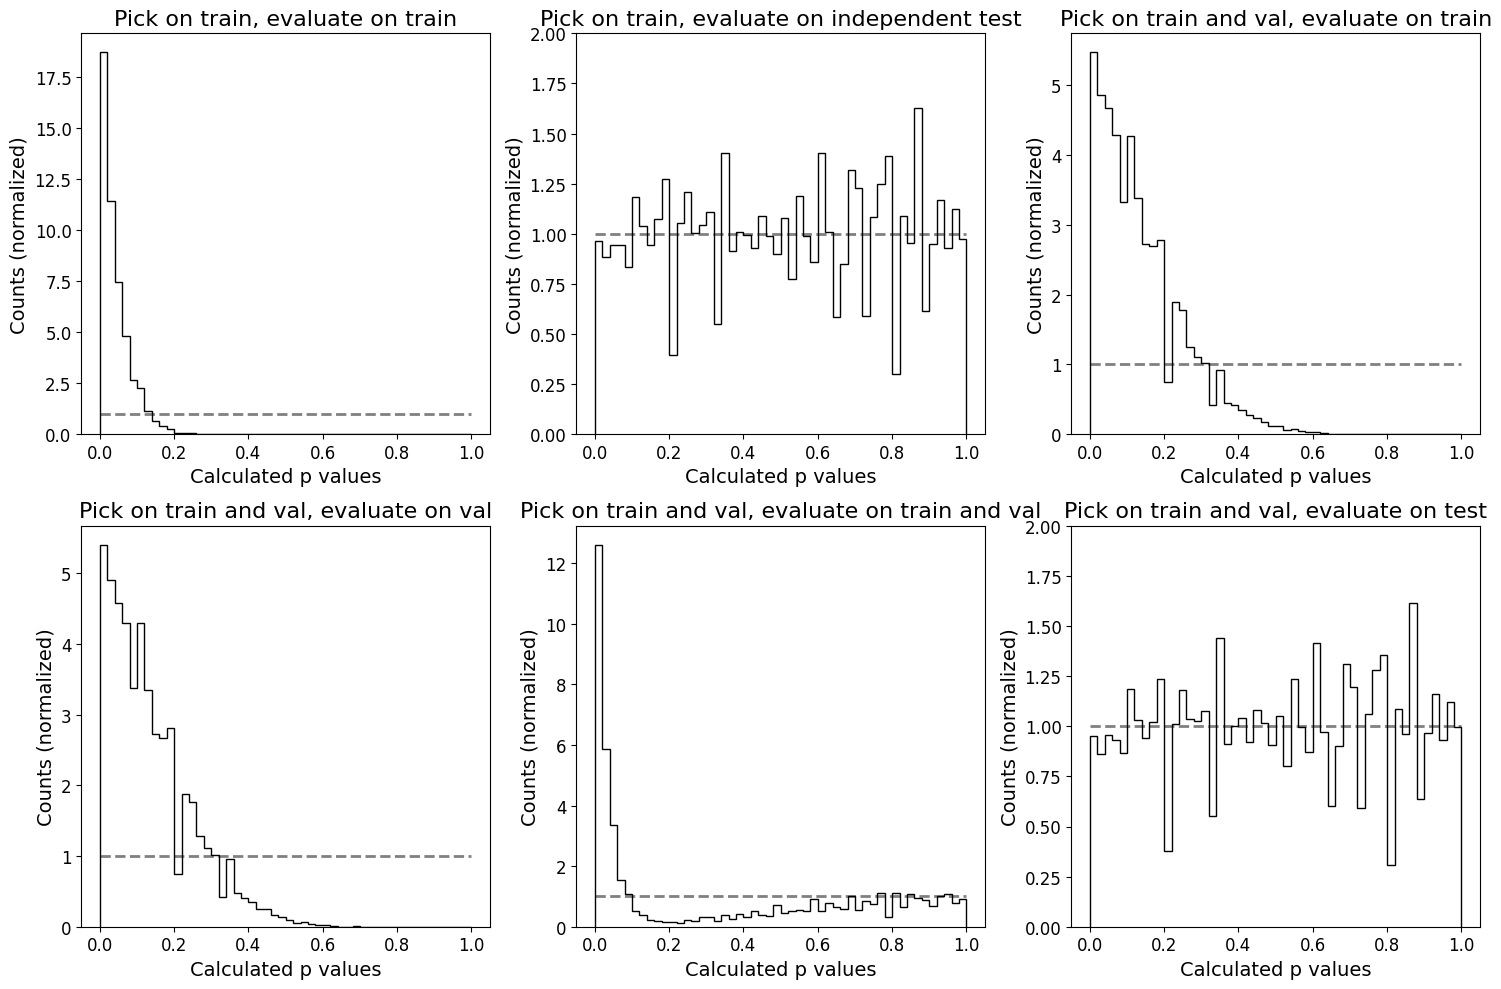

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=np.linspace(0,1,51)
bins_center = 0.5*(bins_plot[1:]+bins_plot[:-1])
norming = N_tests*1/(len(bins_plot)-1)

p_train_pick_on_train = np.load(directory+"validation/p_train_pick_on_train.npy")
p_train_pick_on_train_val = np.load(directory+"validation/p_train_pick_on_train_val.npy")
p_test_pick_on_train = np.load(directory+"validation/p_test_pick_on_train.npy")
p_test_pick_on_train_val = np.load(directory+"validation/p_test_pick_on_train_val.npy")
p_val_pick_on_train_val = np.load(directory+"validation/p_val_pick_on_train_val.npy")
p_train_val_pick_on_train_val = np.load(directory+"validation/p_train_val_pick_on_train_val.npy")


for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")

y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("Pick on train, evaluate on train")

y,_, _ = ax[1].hist(p_test_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("Pick on train, evaluate on independent test")
ax[1].set_ylim(0,2)

ax[2].hist(p_train_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[2].set_title("Pick on train and val, evaluate on train")


ax[3].hist(p_val_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[3].set_title("Pick on train and val, evaluate on val")

ax[4].hist(p_train_val_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[4].set_title("Pick on train and val, evaluate on train and val")

ax[5].hist(p_test_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[5].set_title("Pick on train and val, evaluate on test")
ax[5].set_ylim(0,2)

fig.tight_layout()
fig.savefig("plots/binned_histograms.pdf")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


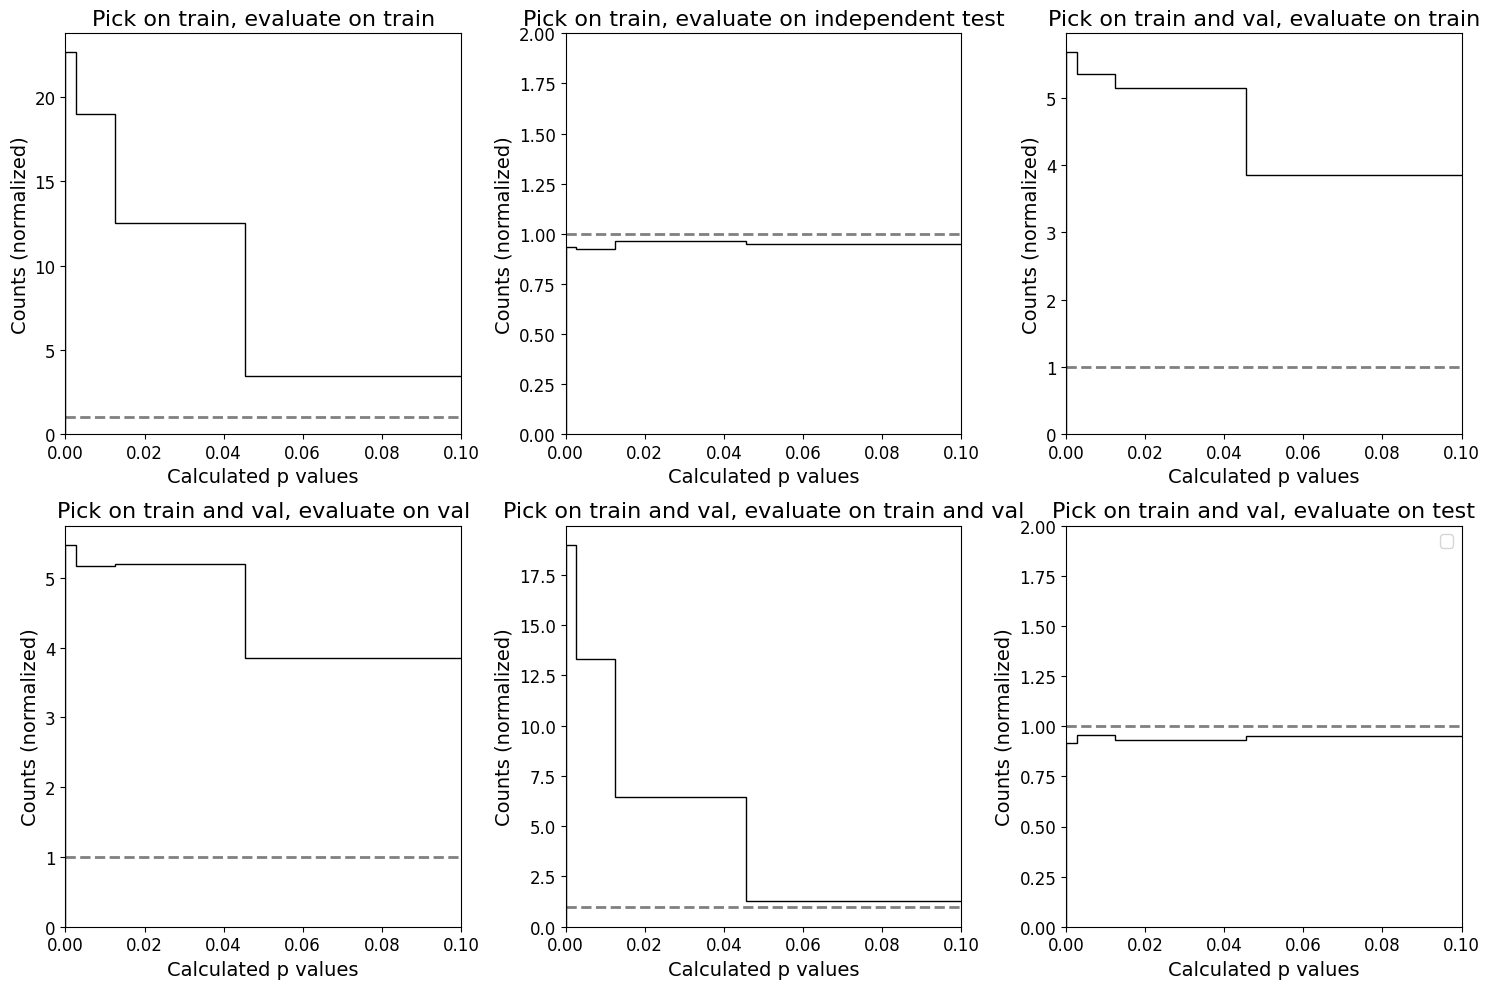

In [5]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]

p_train_pick_on_train = np.load(directory+"validation/p_train_pick_on_train.npy")
p_train_pick_on_train_val = np.load(directory+"validation/p_train_pick_on_train_val.npy")
p_test_pick_on_train = np.load(directory+"validation/p_test_pick_on_train.npy")
p_test_pick_on_train_val = np.load(directory+"validation/p_test_pick_on_train_val.npy")
p_val_pick_on_train_val = np.load(directory+"validation/p_val_pick_on_train_val.npy")
p_train_val_pick_on_train_val = np.load(directory+"validation/p_train_val_pick_on_train_val.npy")


for i in range(len(ax)):
    ax[i].set_xlabel("Calculated p values")
    ax[i].set_ylabel("Counts (normalized)")
    ax[i].plot([0,1],[1,1], linestyle="dashed", color="grey")

y, _, _ = ax[0].hist(p_train_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[0].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[0].set_title("Pick on train, evaluate on train")

y,_, _ = ax[1].hist(p_test_pick_on_train, bins=bins_plot, histtype="step", color="black", density=True)
#ax[1].errorbar(bins_center, y, yerr=np.sqrt(y*norming)/norming, color="black", fmt=".")
ax[1].set_title("Pick on train, evaluate on independent test")
ax[1].set_ylim(0,2)

ax[2].hist(p_train_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[2].set_title("Pick on train and val, evaluate on train")


ax[3].hist(p_val_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[3].set_title("Pick on train and val, evaluate on val")

ax[4].hist(p_train_val_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[4].set_title("Pick on train and val, evaluate on train and val")

ax[5].hist(p_test_pick_on_train_val, bins=bins_plot, histtype="step", color="black", density=True)
ax[5].set_title("Pick on train and val, evaluate on test")
ax[5].set_ylim(0,2)
ax[5].legend()

for i in range(len(ax)):
    ax[i].set_xlim(0,0.1)

fig.tight_layout()
fig.savefig("plots/binned_histograms_sigmas.pdf")

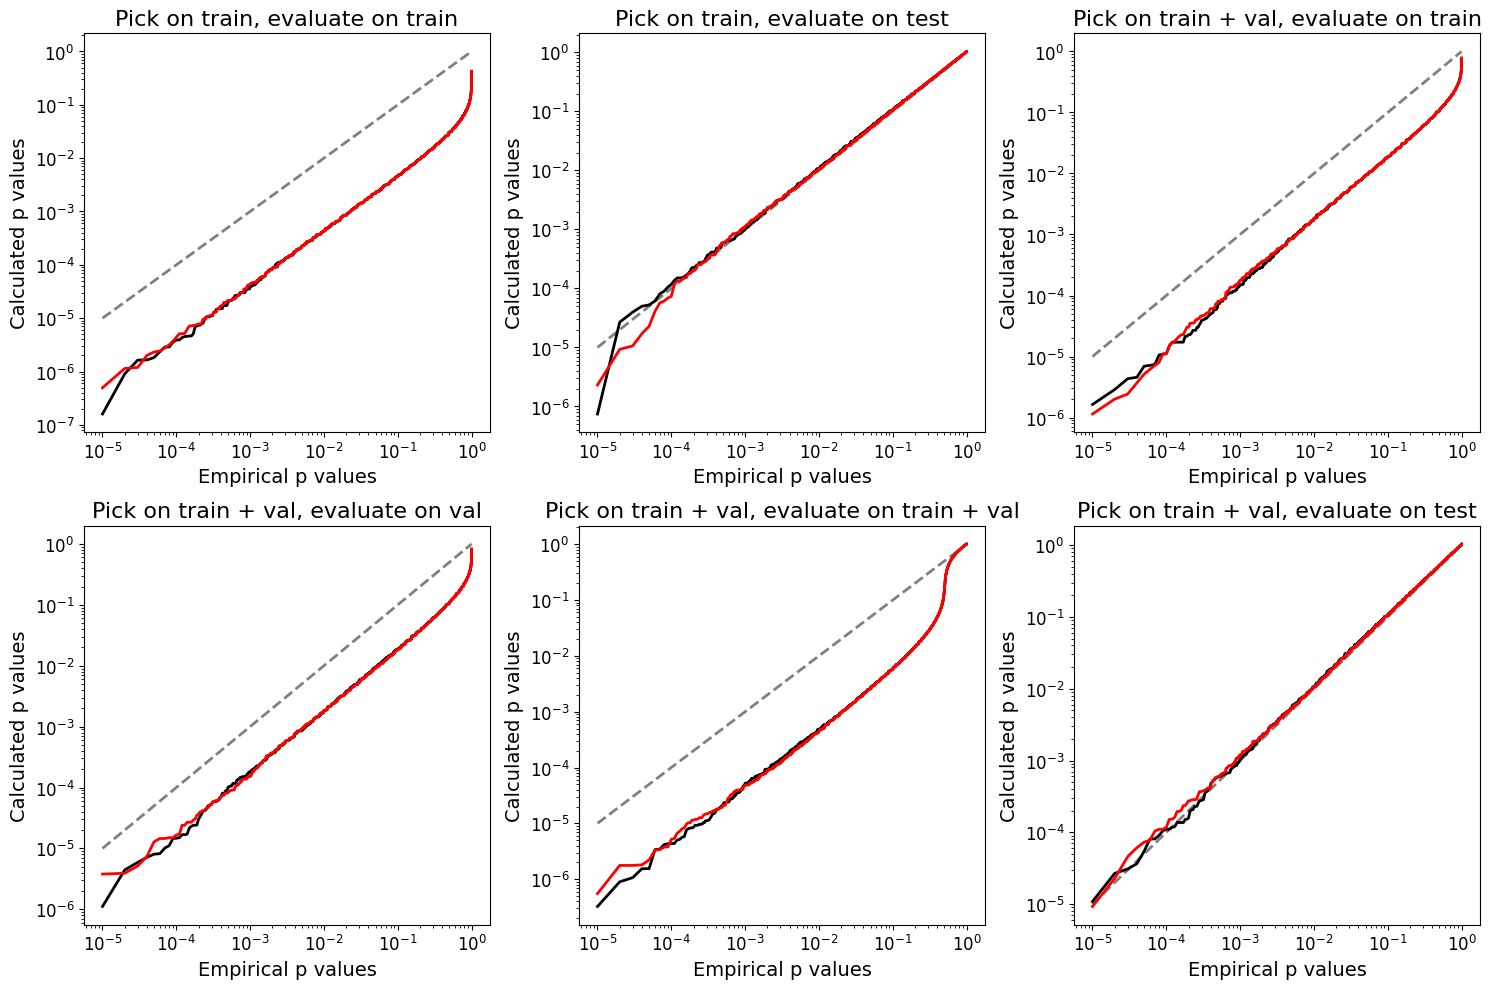

In [30]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
ax = ax.flatten()
counts = np.arange(1,N_tests+1)/N_tests

p_train_pick_on_train = np.load(directory+"validation/p_train_pick_on_train.npy")
p_train_pick_on_train_val = np.load(directory+"validation/p_train_pick_on_train_val.npy")
p_test_pick_on_train = np.load(directory+"validation/p_test_pick_on_train.npy")
p_test_pick_on_train_val = np.load(directory+"validation/p_test_pick_on_train_val.npy")
p_val_pick_on_train_val = np.load(directory+"validation/p_val_pick_on_train_val.npy")
p_train_val_pick_on_train_val = np.load(directory+"validation/p_train_val_pick_on_train_val.npy")


p_train_pick_on_train_alt = np.load(directory+"validation/p_train_pick_on_train_alt.npy")
p_train_pick_on_train_val_alt = np.load(directory+"validation/p_train_pick_on_train_val_alt.npy")
p_test_pick_on_train_alt = np.load(directory+"validation/p_test_pick_on_train_alt.npy")
p_test_pick_on_train_val_alt = np.load(directory+"validation/p_test_pick_on_train_val_alt.npy")
p_val_pick_on_train_val_alt = np.load(directory+"validation/p_val_pick_on_train_val_alt.npy")
p_train_val_pick_on_train_val_alt = np.load(directory+"validation/p_train_val_pick_on_train_val_alt.npy")


p_fisher = np.load(directory+"k_fold/fishers_method.npy")
p_add = np.load(directory+"k_fold/addition.npy")
p_fisher_with_val = np.load(directory+"k_fold/fishers_method_with_validation.npy")
p_add_with_val = np.load(directory+"k_fold/addition_with_validation.npy")


for i in range(len(ax)):
    ax[i].set_xlabel("Empirical p values")
    ax[i].set_ylabel("Calculated p values")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot(counts, counts, color="grey", linestyle="dashed")

ax[0].plot(counts, np.sort(p_train_pick_on_train), color="black")
ax[0].plot(counts, np.sort(p_train_pick_on_train_alt), color="red")
ax[0].set_title("Pick on train, evaluate on train")

ax[1].plot(counts, np.sort(p_test_pick_on_train), color="black")
ax[1].plot(counts, np.sort(p_test_pick_on_train_alt), color="red")
ax[1].set_title("Pick on train, evaluate on test")


ax[2].plot(counts, np.sort(p_train_pick_on_train_val), color="black")
ax[2].plot(counts, np.sort(p_train_pick_on_train_val_alt), color="red")
ax[2].set_title("Pick on train + val, evaluate on train")


ax[3].plot(counts, np.sort(p_val_pick_on_train_val), color="black")
ax[3].plot(counts, np.sort(p_val_pick_on_train_val_alt), color="red")
ax[3].set_title("Pick on train + val, evaluate on val")

ax[4].plot(counts, np.sort(p_train_val_pick_on_train_val), color="black", label="Val")
ax[4].plot(counts, np.sort(p_train_val_pick_on_train_val_alt), color="red", label="Alt")
ax[4].set_title("Pick on train + val, evaluate on train + val")


ax[5].plot(counts, np.sort(p_test_pick_on_train_val), color="black", label="Train + Val")
ax[5].plot(counts, np.sort(p_test_pick_on_train_val_alt), color="red", label="Alt")
#ax[5].hist((p_fisher_with_val, p_add_with_val), bins=bins_plot, histtype="step", color=("black", "red"), label=("Fisher", "Addition"), density=True)
ax[5].set_title("Pick on train + val, evaluate on test")

fig.tight_layout()
fig.savefig("plots/binned_cumulative.pdf")

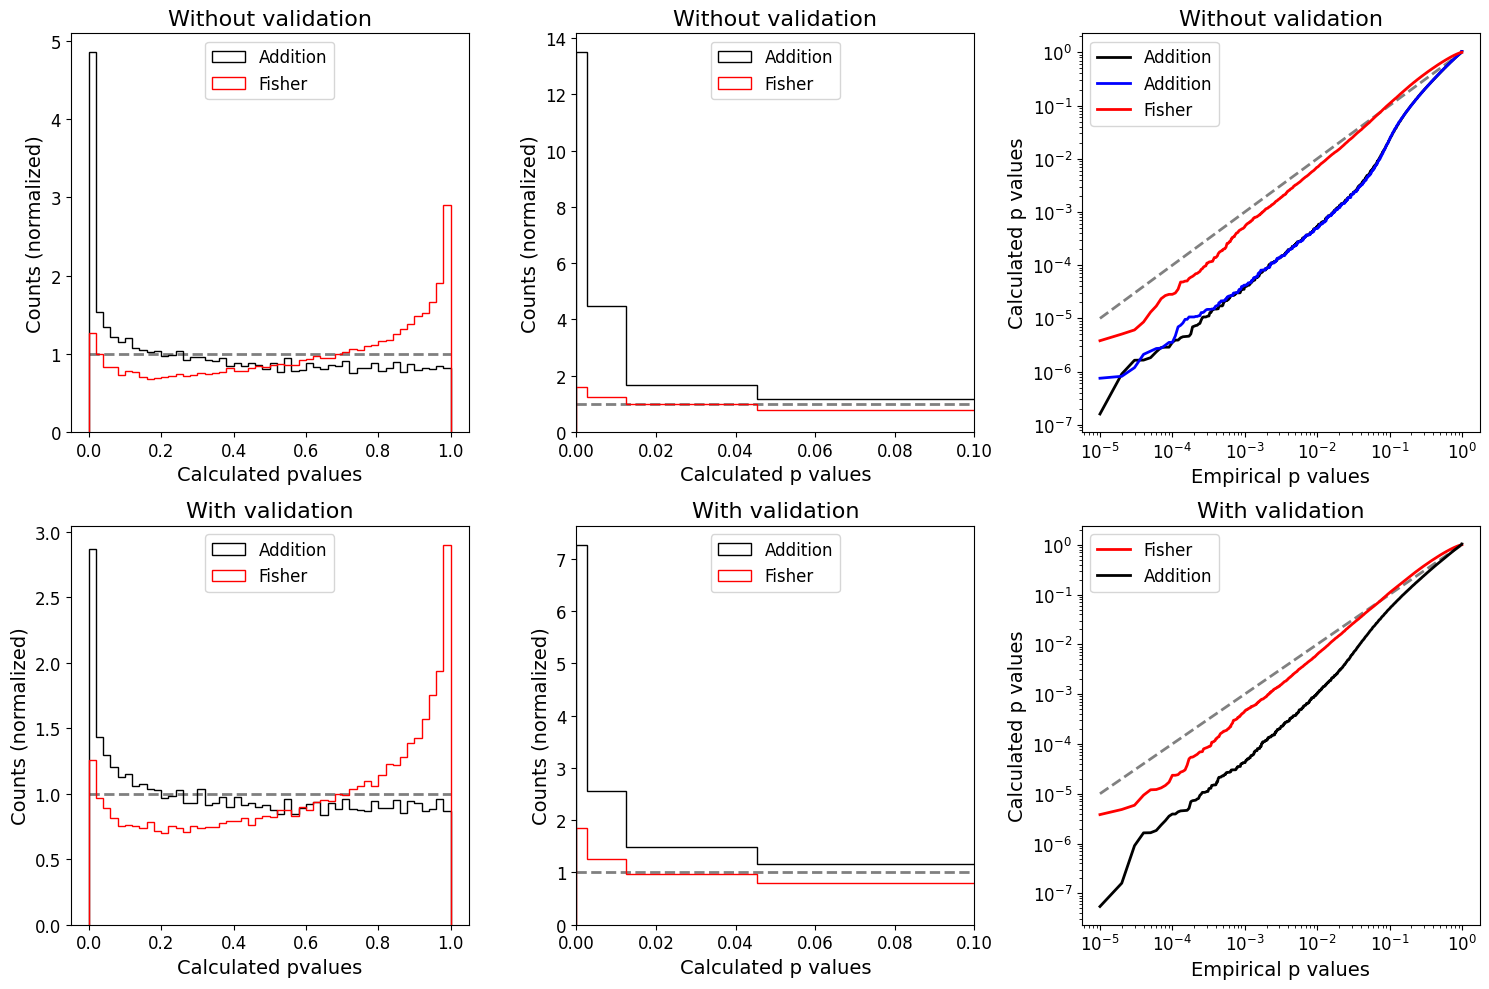

In [63]:
p_fisher = np.load(directory+"k_fold/fishers_method.npy")
p_add = np.load(directory+"k_fold/addition.npy")
p_fisher_with_val = np.load(directory+"k_fold/fishers_method_with_validation.npy")
p_add_with_val = np.load(directory+"k_fold/addition_with_validation.npy")
p_add_test = np.load(directory+"k_fold/addition_method_test.npy")

fig, ax = plt.subplots(2,3, figsize=(15,10))
counts = np.arange(1,N_tests+1)/N_tests
bins_plot=np.linspace(0,1,51)

for i in range(2):
    ax[i,0].set_xlabel("Calculated pvalues")
    ax[i,0].set_ylabel("Counts (normalized)")
    ax[i,0].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,1].set_xlabel("Calculated p values")
    ax[i,1].set_ylabel("Counts (normalized)")
    ax[i,1].plot([0,1],[1,1], linestyle="dashed", color="grey")

    ax[i,2].set_xlabel("Empirical p values")
    ax[i,2].set_ylabel("Calculated p values")
    ax[i,2].set_xscale("log")
    ax[i,2].set_yscale("log")
    ax[i,2].plot(counts, counts, color="grey", linestyle="dashed")

ax[0,0].hist((p_fisher, p_add), bins=bins_plot, histtype="step", color=("red", "black"), label=("Fisher", "Addition"), density=True)
ax[0,0].set_title("Without validation")
ax[0,0].legend(loc="upper center")

ax[1,0].hist((p_fisher_with_val, p_add_with_val), bins=bins_plot, histtype="step", color=("red", "black"), label=("Fisher", "Addition"), density=True)
ax[1,0].set_title("With validation")
ax[1,0].legend(loc="upper center")

bins_plot=[0, 2-2*stats.norm.cdf(3), 2-2*stats.norm.cdf(2.5), 2-2*stats.norm.cdf(2), 2-2*stats.norm.cdf(1.5), 2-2*stats.norm.cdf(1), 1]
ax[0,1].hist((p_fisher, p_add), bins=bins_plot, histtype="step", color=("red", "black"), label=("Fisher", "Addition"), density=True)
ax[0,1].set_title("Without validation")
ax[0,1].legend(loc="upper center")
ax[0,1].set_xlim(0,0.1)

ax[1,1].hist((p_fisher_with_val, p_add_with_val), bins=bins_plot, histtype="step", color=("red", "black"), label=("Fisher", "Addition"), density=True)
ax[1,1].set_title("With validation")
ax[1,1].legend(loc="upper center")
ax[1,1].set_xlim(0,0.1)

counts = np.arange(1,N_tests+1)/N_tests

ax[0,2].plot(counts, np.sort(p_add), color="black", label="Addition")
ax[0,2].plot(counts, np.sort(p_add_test), color="blue", label="Addition")
ax[0,2].plot(counts, np.sort(p_fisher), color="red", label="Fisher")
ax[0,2].set_title("Without validation")
ax[0,2].legend(loc="upper left")

ax[1,2].plot(counts, np.sort(p_fisher_with_val), color="red", label="Fisher")
ax[1,2].plot(counts, np.sort(p_add_with_val), color="black", label="Addition")
ax[1,2].set_title("With validation")
ax[1,2].legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/binned_kfolds.pdf")

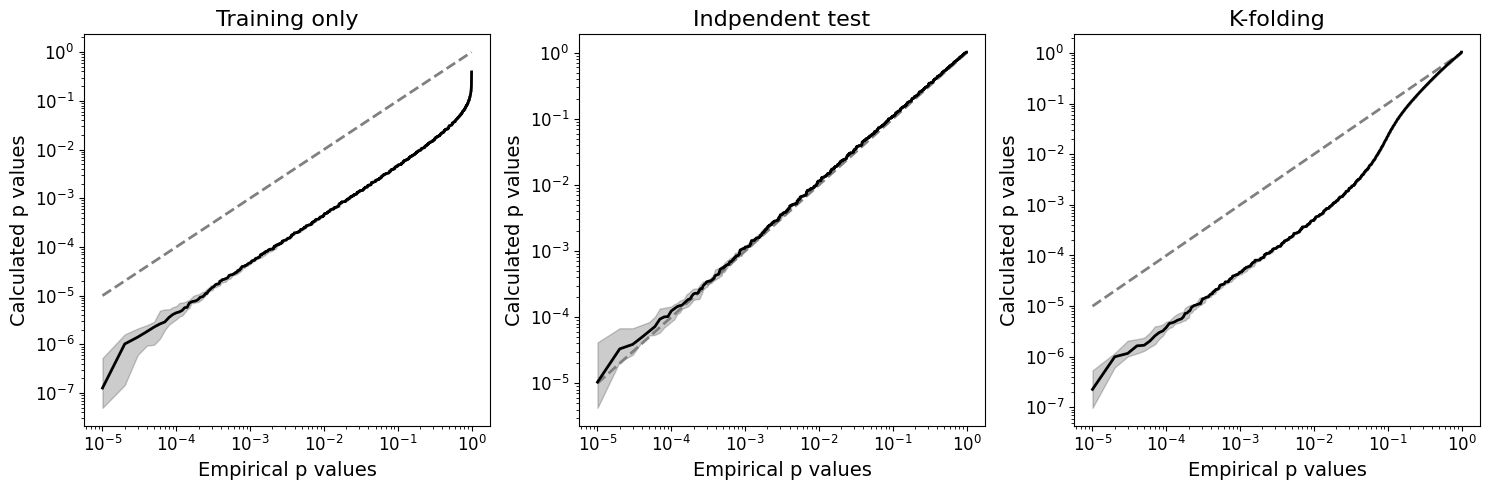

In [90]:
p_train = np.load(directory+"validation/p_train_10_tests.npy")
p_train_half = np.load(directory+"validation/p_train_10_tests_half.npy")
p_test = np.load(directory+"validation/p_test_10_tests.npy")
p_test_half = np.load(directory+"validation/p_test_10_tests_half.npy")
p_kfold = np.load(directory+"k_fold/addition_method_test.npy")

fig, ax = plt.subplots(1,3, figsize=(15,5))
counts = np.arange(1,N_tests+1)/N_tests
bins_plot=np.linspace(0,1,51)

for i in range(3):
    ax[i].set_xlabel("Empirical p values")
    ax[i].set_ylabel("Calculated p values")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].plot(counts, counts, color="grey", linestyle="dashed")

counts = np.arange(1,N_tests+1)/N_tests

p_trains = np.sort([np.sort(p_train[i]) for i in range(10)])
p_trains_half = np.sort([np.sort(p_train_half[i]) for i in range(10)])
p_tests = np.sort([np.sort(p_test[i]) for i in range(10)])
p_tests_half = np.sort([np.sort(p_test_half[i]) for i in range(10)])
p_kfolds = np.sort([np.sort(p_kfold[i]) for i in range(10)])

ax[0].plot(counts, np.median(p_trains, axis=0), color="black", label="Full")
ax[0].fill_between(counts, np.percentile(p_trains,16, axis=0),np.percentile(p_trains,84, axis=0), color="black", label=None, alpha=0.2)
ax[0].set_title("Training only")
#ax[0].legend(loc="upper left")

ax[1].plot(counts, np.median(p_tests_half, axis=0), color="black", label="Half")
ax[1].fill_between(counts, np.percentile(p_tests_half,16, axis=0),np.percentile(p_tests_half,84, axis=0), color="black", label=None, alpha=0.2)
ax[1].set_title("Indpendent test")
#ax[1].legend(loc="upper left")

ax[2].plot(counts, np.median(p_kfolds, axis=0), color="black", label="Full")
ax[2].fill_between(counts, np.percentile(p_kfolds,16, axis=0),np.percentile(p_kfolds,84, axis=0), color="black", label="Full", alpha=0.2)
ax[2].set_title("K-folding")
#ax[1].legend(loc="upper left")

fig.tight_layout()
fig.savefig("plots/binned_pvalues.pdf")